In [ ]:
"""
Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
"""

### Load dependencies

In [12]:
%load_ext autoreload
%autoreload 2
import cil
print(f'cil.__version__ = {cil.__version__}')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
cil.__version__ = 24.3.0


In [13]:
import numpy as np
import matplotlib.pyplot as plt

from cil.framework import AcquisitionGeometry
from cil.optimisation.functions import LeastSquares, TotalVariation
from cil.plugins.astra import ProjectionOperator
from cil.optimisation.algorithms import FISTA
from cil.utilities.display import show2D, show_geometry
from cil.utilities.jupyter import islicer
from cil.io import TIFFStackReader

### Read keyboard PCA datafile for parameters

In [14]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from util.pcaReader import read_pca_file

filepath = '../keyboard_1/keyboard.pca'
params = read_pca_file(filepath)

196 lines, found 143 values (discarded 124)


### Parameters of the CT-scan

In [15]:
from util.getParameters import get_ct_parameters

# Reads all the necessary parameters for the reconstruction.
SOD, SDD, ODD, pixel_size, num_pixels, num_projs, max_k = get_ct_parameters(params)

SOD: 150.595 mm
SDD: 648.629 mm
ODD: 498.035 mm
Detector pixel size: 0.200 mm
Projection image size: 1000 x 1000
1080 projection angles used
White level intensity: 14357


### Setting up the Acquistion geometry

In [16]:
from util.setAcquisitionGeometry import set_ct_acquisition_geometry

ag_big = set_ct_acquisition_geometry(
    params=params,
    skip=10)

SOD: 150.595 mm
SDD: 648.629 mm
ODD: 498.035 mm
Detector pixel size: 0.200 mm
Projection image size: 1000 x 1000
1080 projection angles used
White level intensity: 14357
3D Cone-beam tomography
System configuration:
	Source position: [   0.        , -150.59470833,    0.        ]
	Rotation axis position: [0., 0., 0.]
	Rotation axis direction: [0., 0., 1.]
	Detector position: [  0.        , 498.03460667,   0.        ]
	Detector direction x: [1., 0., 0.]
	Detector direction y: [0., 0., 1.]
Panel configuration:
	Number of pixels: [1000 1000]
	Pixel size: [0.2 0.2]
	Pixel origin: bottom-right
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 108
	Angles 0-9 in degrees: [ 0.       ,  3.3333333,  6.6666665, 10.       , 13.333333 , 16.666666 ,
 20.       , 23.333334 , 26.666666 , 30.       ]
	Angles 98-107 in degrees: [326.66666, 330.     , 333.33334, 336.66666, 340.     , 343.33334,
 346.66666, 350.     , 353.33334, 356.66666]
	Full angular array can

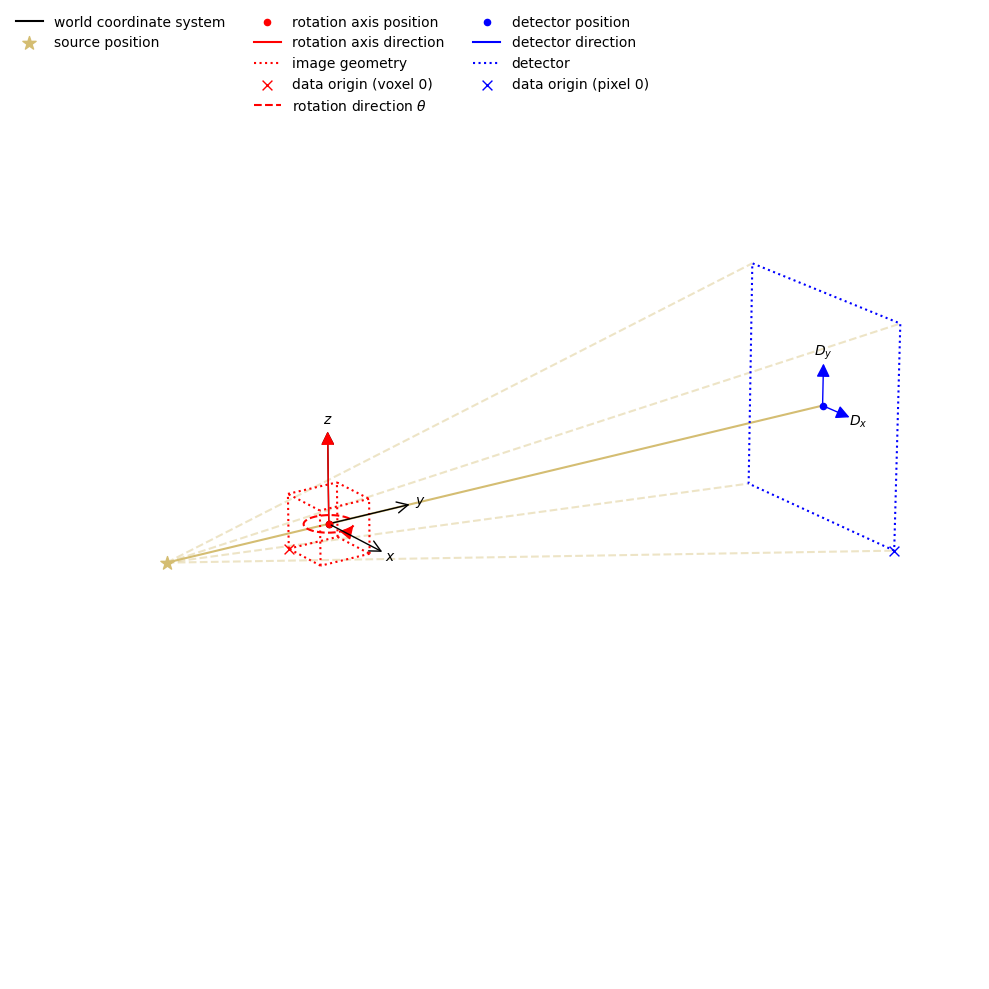

In [10]:
show_geometry(ag_big)

### Read the CT-scan data from the .tif files

Number of dimensions: 3
Shape: (108, 1000, 1000)
Axis labels: (<AcquisitionDimension.ANGLE: 'angle'>, <AcquisitionDimension.VERTICAL: 'vertical'>, <AcquisitionDimension.HORIZONTAL: 'horizontal'>)



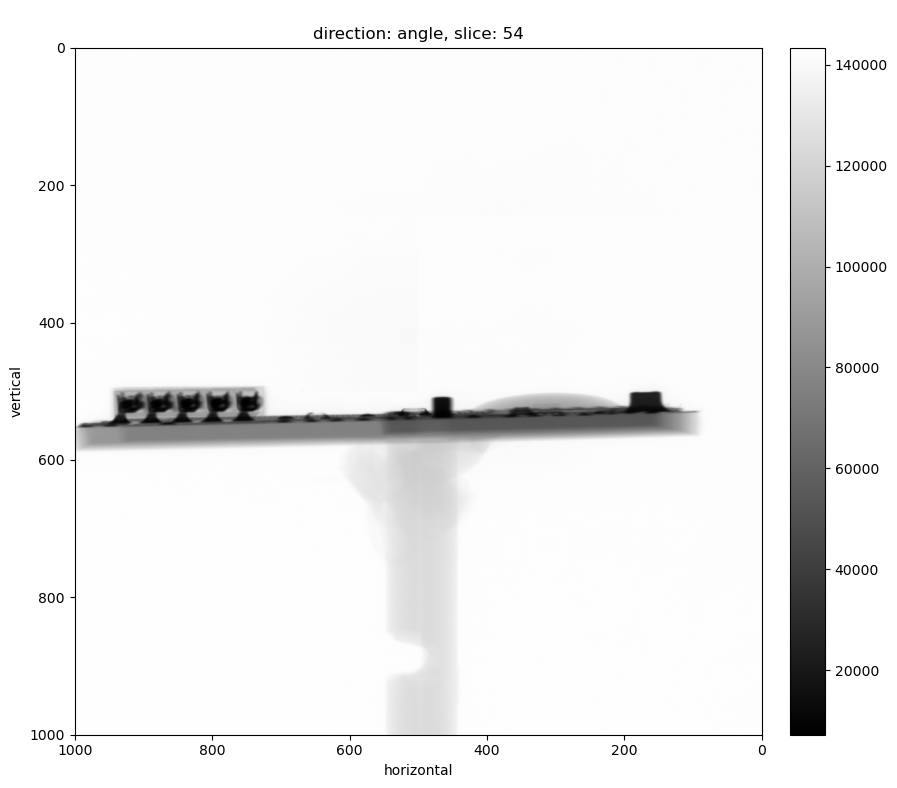

In [19]:
from util.readData import read_ct_data

aq_data = read_ct_data(
    filename='../keyboard_1',
    acquisition_geometry=ag_big,
    num_projections=num_projs
    )

### Convert the transmission data to the absorption data

white_level = 14357, about 87.628 of the maximum (of 14 bit int)


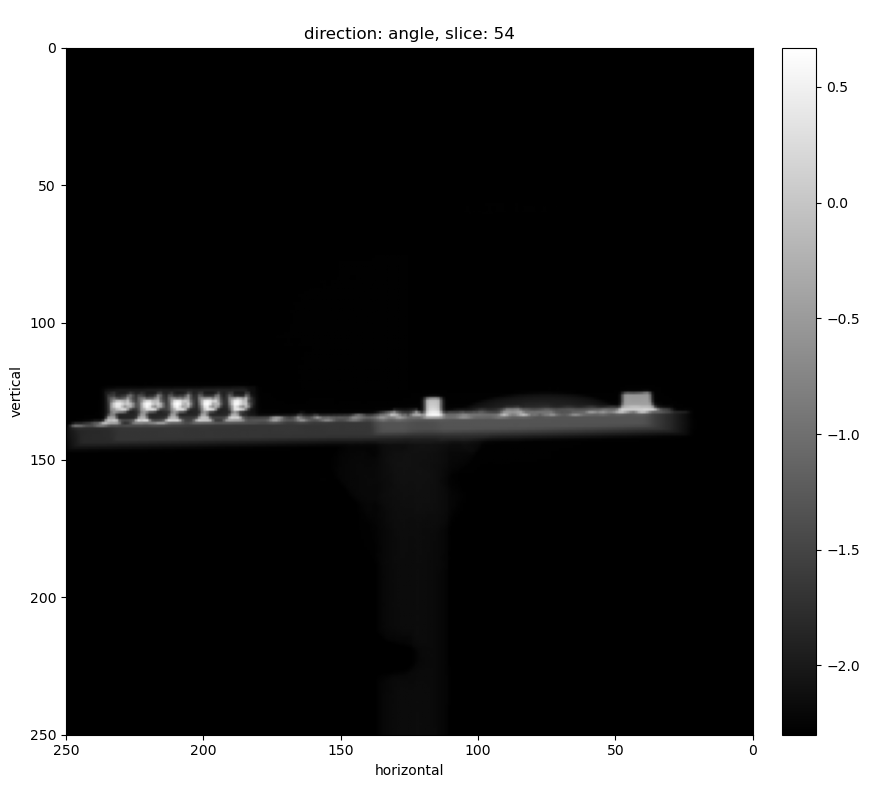

Number of dimensions: 3
Shape: (108, 250, 250)
Axis labels: (<AcquisitionDimension.ANGLE: 'angle'>, <AcquisitionDimension.VERTICAL: 'vertical'>, <AcquisitionDimension.HORIZONTAL: 'horizontal'>)



In [20]:
from util.convertData import convert_ct_data

data = convert_ct_data(aq_data, max_k)

# Delete acquistion data to save memory
del aq_data

### Convert fan-beam sinogram to parallel-beam sinogram 

Rebinning is complete.
Shape of the parallel-beam sinogram: (247, 55).
Shape of the parallel-beam sensor locations vector: (247,)
Shape of the parallel-beam angles: (55,).


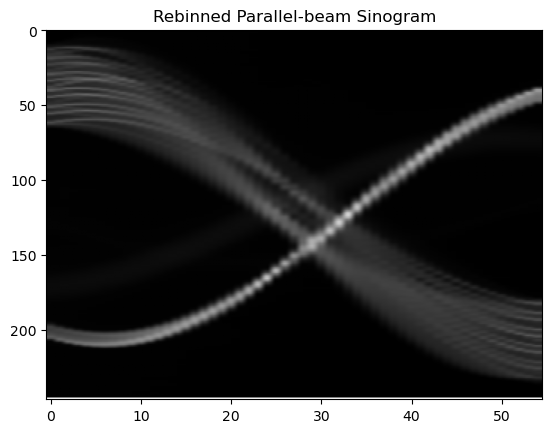

In [22]:
from util.fanToPara import convert_fan_to_parallel_geometry
idx = 125
Psinogram, Ploc, Pangles = convert_fan_to_parallel_geometry(data, idx, SOD, direction=False)

Save sinogram, sensor locations and angles, and then move to the other project

In [ ]:
# np.save(f"Psinogram_{idx}.npy", Psinogram)
# np.save(f"Ploc_{idx}.npy", Ploc)
# np.save(f"Pangles_{idx}.npy", Pangles)
# !mv Psinogram_{idx}.npy Ploc_{idx}.npy Pangles_{idx}.npy /home/santtalainen/Reconstructions/KernelCT/Data/

### Reconstruct using the parallel-beam sinogram

Reconstruction complete.


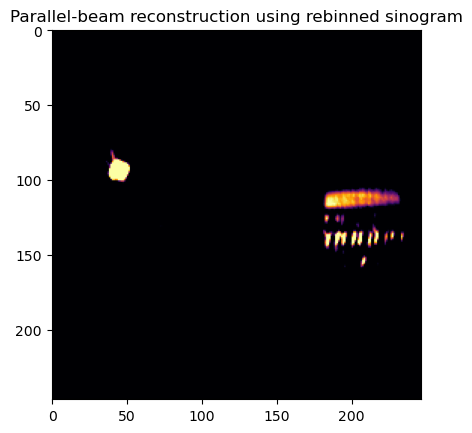

In [13]:
from util.fanToPara import reconstruct_parallel_sinogram

recon = reconstruct_parallel_sinogram(
    parallel_sinogram=Psinogram,
    parallel_angles=Pangles,
    filter_name='hamming',
    interpolation='linear',
    lower_bound=0,
    upper_bound=0.01,
    cmap='inferno'
    )

### Save parallel-beam sinogram and angles for testing

In [ ]:
# import h5py

# output_file = 'parallel_beam_data.h5'

# with h5py.File(output_file, 'w') as f:
#     f.create_dataset('sinogram', data=Psinogram.T)
#     f.create_dataset('angles', data=Pangles)